# The Lindblad equation

We consider the Hamiltonian

$$
    H(r, \theta, p_r, p_\theta) = p_r\, \mu(r) + \Vert p \Vert_{g}
$$

where

$$
    \mu(r) = \delta \sin 2r, \quad 
    \Vert p \Vert_{g} =  \sqrt{ p_r^2 + \frac{p_\theta^2}{m_\lambda^2(r)} }, \quad
    m_\lambda^2(r) = \frac{\sin^2 r}{1 - \lambda \sin^2 r}
$$

and where $\delta$ and $\lambda$ are constants. 
We will fix $\delta > 1$ (strong Zermelo case) and $\lambda = 4/5$.
Along the geodesics, we have $H+p^0 = 0$. The parameter $p^0$ is constant equal to $-1$ (hyperbolic), $0$ (abnormal) or $1$ (elliptic).

**Remark.** We can parameterize the geodesics by the norm of the initial convector, setting $\Vert{p_0}\Vert_g = 1$. 
This amounts to parameterize by the initial angle $\alpha_0$:
$$
    p_r = \sin \alpha_0, \quad p_\theta = m_\lambda(r) \cos \alpha_0.
$$
In that case, the hyperbolic geodeics are given by
$$
    p_r\, \mu(r) + 1 = \sin(\alpha_0)\, \delta \sin(2r) + 1 > 0.
$$

## Packages

In [1]:
import sys
sys.path.insert(1, '../')
#
import math
import numpy as np              # scientific computing tools
import wrappers                 # for compilation of Fortran Hamiltonian codes
import geometry2d.database
import geometry2d.conjugate
import geometry2d.errors
import geometry2d.geodesic
import geometry2d.plottings
import geometry2d.problem
import geometry2d.splitting
import geometry2d.utils
import geometry2d.wavefront
import geometry2d.sphere
import matplotlib.pyplot as plt # for plots
import nutopy as nt
%matplotlib inline

In [2]:
#
color_hyperbolic = 'red'
color_elliptic   = 'blue'
color_abnormal   = 'green'
color_cut_locus  = 'black'
color_conjugate  = 'magenta'
color_wavefront = 'orange'
color_sphere     = 'orange'
#
color_strong_domain_2d = 'lightblue'
color_strong_domain_3d = 'blue'
#
PLANE = geometry2d.plottings.Coords.PLANE
SPHERE = geometry2d.plottings.Coords.SPHERE

## Fortran Hamiltonian code

In [3]:
# print Fortran code of the Hamiltonian: print hfun.f90 file
with open('hfun.f90', 'r') as f:
    print(f.read())

! Lindblad
subroutine hfun(x, p, d, h)

    double precision, intent(in)  :: x(2), p(2), d
    double precision, intent(out) :: h

    ! local variables
    double precision :: r, th, pr, pth
    double precision :: l, m2, mu

    r   = x(1)
    th  = x(2)

    pr  = p(1)
    pth = p(2)

    l   = 4d0/5d0
    m2  = sin(r)**2/(1d0-l*sin(r)**2)
    mu  = d*sin(2*r)

    h   = mu*pr + sqrt(pr**2 + pth**2/m2)

end subroutine hfun


## Initializations

In [4]:
def initialize(d, r0):

    # Parameters
    #d  = -1.25        # strong Zermelo case
    #r0 = np.pi/2.0 #+ 3.0*np.pi/8.0 # initial azimuth
    θ0 = 0.0        # initial latitude
    t0 = 0.0        # initial time

    name = 'lindblad_strong' # name of the problem

    # Initialize data
    data_file = 'data_lindblad_strong.json'
    restart   = False # restart or not the computations
    data      = geometry2d.database.Data({'name': name,
                        't0': t0, 
                        'r0': r0, 
                        'θ0': θ0, 
                        'd': d}, data_file, restart)

    # Initial point
    q0 = np.array([r0, θ0])

    # Hamiltonian and derivatives up to order 3
    H = wrappers.hamiltonian(d, compile=False, display=False)

    # The Riemannian metric associated to the Zermelo problem
    # g = g1 dr^2 + g2 dθ^2
    def g(q):
        λ  = 4.0/5.0
        r  = q[0] 
        g1 = 1.0
        g2 = np.sin(r)**2/(1.0-λ*np.sin(r)**2)
        return g1, g2

    # problem
    prob = geometry2d.problem.GeometryProblem2D(name, H, g, t0, q0, data, steps_for_geodesics=200, modulo=2.0*np.pi)
    
    return prob

## Parameterization of the geodesics

In [48]:
# we parameterize ||p(0)|| = 1 by the angle α0
# the norm being given by the metric g: p(0) = (sin(α0)*g1, cos(α0)*g2) = (sin(α0), cos(α0)*g2), since g1 = 1
# get the values of α0 for which h = pr mu(r) + 1 > 0
#
# first get the values of α for which h = pr mu(r) + 1 = 0
def mu_fun(r, d):
    return d*np.sin(2*r)

def pr_fun(α):
    return np.sin(α)

def h_fun(r, α, d):
    return pr_fun(α)*mu_fun(r, d) + 1.0

def α0_fun(r, d):
    return np.arcsin(-1.0/mu_fun(r, d))

# get the values of α0 for which h = pr mu(r) + 1 > 0
def α_hyperbolique_1(r, d):
    m = mu_fun(r, d)
    if abs(m) > 1.0:
        α = α0_fun(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return np.pi - α
        else:
            return α
    else:
        return 0.0

def α_hyperbolique_2(r, d):
    m = mu_fun(r, d)
    if abs(m) > 1.0:
        α = α0_fun(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return 2.0*np.pi + α
        else:
            return np.pi - α
    else:
        return 2.0*np.pi

def α_hyperbolique_span(r, d, *, N=20):
    m = mu_fun(r, d)
    if abs(m) <= 1.0 and np.abs(r - np.pi/2.0) < 1.0e-6:
        αspan_top_right = np.logspace(-6, np.log10(np.pi/2), N//4)
        αspan_top_left  = np.pi - αspan_top_right
        αspan_bot_left  = np.pi + αspan_top_right
        αspan_bot_right = 2.0*np.pi - αspan_top_right
        return np.concatenate((αspan_top_right, αspan_top_left, αspan_bot_left, αspan_bot_right))
    else:
        α1 = α_hyperbolique_1(r, d)
        α2 = α_hyperbolique_2(r, d)
        return np.linspace(α1, α2, N)

# get the values of α0 for which h = pr mu(r) + 1 < 0
def α_elliptique_1(r, d):
    m = mu_fun(r, d)
    if abs(m) > 1.0:
        α = α0_fun(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return α
        else:
            return np.pi - α
    else:
        # raise an error: there is no elliptic domain
        raise geometry2d.errors.ArgumentValueError('There is no elliptic domain for this value of d')
    
def α_elliptique_2(r, d):
    m = mu_fun(r, d)
    if abs(m) > 1.0:
        α = α0_fun(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return np.pi - α
        else:
            return α + 2.0*np.pi
    else:
        # raise an error: there is no elliptic domain
        raise geometry2d.errors.ArgumentValueError('There is no elliptic domain for this value of d')
    
def α_elliptique_span(r, d, *, N=20):
    α1 = α_elliptique_1(r, d)
    print('α1 = ', α1)
    α2 = α_elliptique_2(r, d)
    print('α2 = ', α2)
    return np.linspace(α1, α2, N)

def get_strong_domain(d):
    # North hemisphere
    rp1 = math.asin(1/np.abs(d))/2.0
    rp2 = (math.pi - math.asin(1/np.abs(d))) / 2.0

    # South hemisphere
    rm1 = (-math.asin(1/np.abs(d)) % (2*np.pi) )/2.0
    rm2 = (math.pi + math.asin(1/np.abs(d))) / 2.0
    
    return rp1, rp2, rm1, rm2

## Make plots

In [49]:
def update_2d_plot(fig):
    ax = fig.axes[0]
    # set xlims
    ax.set_xlim(-np.pi/3, 2*np.pi + np.pi/3)
    # add vertical lines
    ax.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    ax.axvline(1*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    # set ylabel to "r" 
    ax.set_ylabel(r'$r$', rotation=0, labelpad=10)
    # set yticks: 0 => \pi/2, pi/2 => \pi, -pi/2 => 0
    ax.set_yticks([-np.pi/2, 0.0, np.pi/2])
    ax.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    # set xticks: 0, pi and 2pi
    ax.set_xticks([0.0, np.pi, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
    return fig

def make_plots(r0, d, *, cameras=[{'azimuth': 160, 'elevation': -10}], tf=4.0, N=31, force=False):

    # Initialize the problem
    prob = initialize(d, r0)

    # Strong domain
    rp1, rp2, rm1, rm2 = get_strong_domain(d)

    # Geodesics
    geodesic = geometry2d.geodesic.Geodesic(prob)

    #
    αspan_hyperbolique = α_hyperbolique_span(r0, d, N=N)

    #
    fig2d = geodesic.plot(alphas=αspan_hyperbolique, tf=tf, length=1.0, 
                          view=PLANE, figsize=(4,4), color=color_hyperbolic, force=force)
    fig2d = update_2d_plot(fig2d)
    fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1, rp2, color_strong_domain_2d)
    fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1, rm2, color_strong_domain_2d)

    # cameras is a list of dictionaries containing azimuth and elevetion angles
    figs3d = []
    for cam in cameras:
        azimuth = cam['azimuth']
        elevation = cam['elevation']
        fig3d = geodesic.plot(alphas=αspan_hyperbolique, tf=tf, length=1.0,
            view=SPHERE, azimuth=azimuth, elevation=elevation, figsize=(3,3),
            color=color_hyperbolic, force=force)
        fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
        fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
        figs3d.append(fig3d)
    
    return fig2d, figs3d, prob

## Example 1

In [34]:
d = 1.25
r0 = np.pi/2.0
fig2d, figs3d, prob = make_plots(r0, d, tf=5*np.pi, N=4*15, force=True)
geodesic = geometry2d.geodesic.Geodesic(prob)

<Figure size 640x480 with 0 Axes>

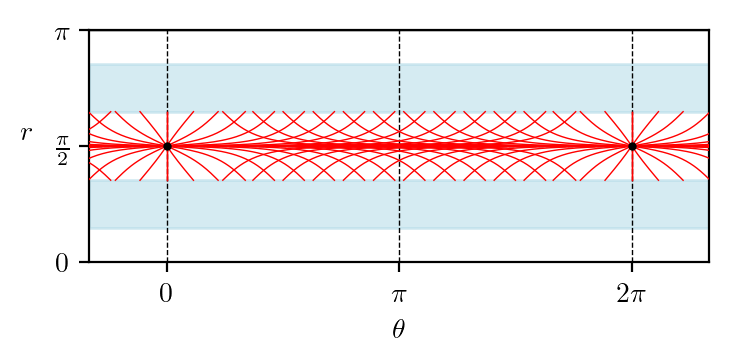

In [40]:
fig2d.savefig('lindblad_d_gt_0_pi_2_2D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d

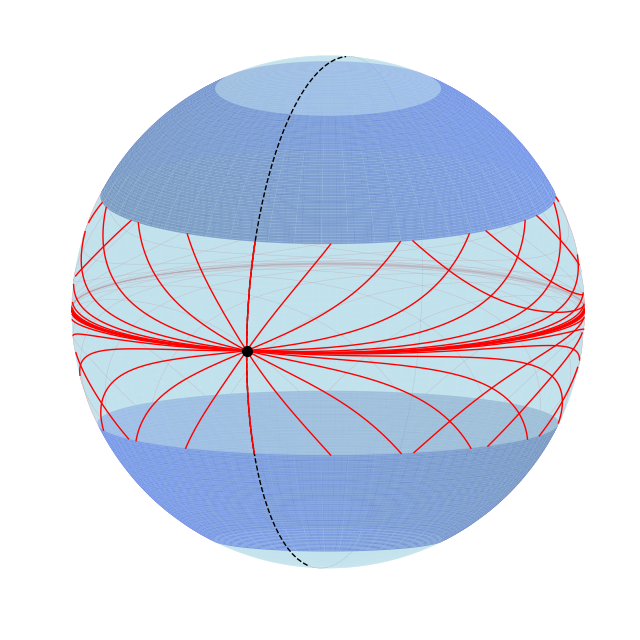

In [41]:
figs3d[0].savefig('lindblad_d_gt_0_pi_2_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

In [37]:
# wavefronts
wavefront = geometry2d.wavefront.WaveFront(prob)
tfs_wavefronts = [1.0, 3.0, 5.0, 7.2]
if True:
    opt = nt.path.Options(Display='off', MaxStepSizeHomPar=0.001, MaxIterCorrection=10)
    for tf in tfs_wavefronts:
        wavefront.compute(tf, options=opt, reset=False)

In [12]:
# Strong domain
rp1, rp2, rm1, rm2 = get_strong_domain(d)
    
tfs = [1.0, 3.0, 5.0, 7.2]
cameras=[{'azimuth': 140, 'elevation': -10}]
for i in range(len(tfs)):
    tf = tfs[i]
    if i == 0:
        fig2d_wavefront = wavefront.plot(tf, view=PLANE, color=color_wavefront, figsize=(5,5))
        fig2d_wavefront = update_2d_plot(fig2d_wavefront)
        fig2d_wavefront = geometry2d.utils.plot_2d_domain(fig2d_wavefront, rp1, rp2, color_strong_domain_2d)
        fig2d_wavefront = geometry2d.utils.plot_2d_domain(fig2d_wavefront, rm1, rm2, color_strong_domain_2d)
        figs3d_wavefront = []
        for camera in cameras:
            azimuth = camera['azimuth']
            elevation = camera['elevation']
            fig3d_wavefront = wavefront.plot(tf, view=SPHERE, color=color_wavefront, 
                                             azimuth=azimuth, elevation=elevation, figsize=(3,3))
            fig3d_wavefront = geometry2d.utils.plot_3d_domain(fig3d_wavefront, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
            fig3d_wavefront = geometry2d.utils.plot_3d_domain(fig3d_wavefront, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
            figs3d_wavefront.append(fig3d_wavefront)
    else:
        wavefront.plot(tf, view=PLANE, color=color_wavefront, figure=fig2d_wavefront)
        for fig3d_wavefront in figs3d_wavefront:
            wavefront.plot(tf, view=SPHERE, color=color_wavefront, figure=fig3d_wavefront)

<Figure size 640x480 with 0 Axes>

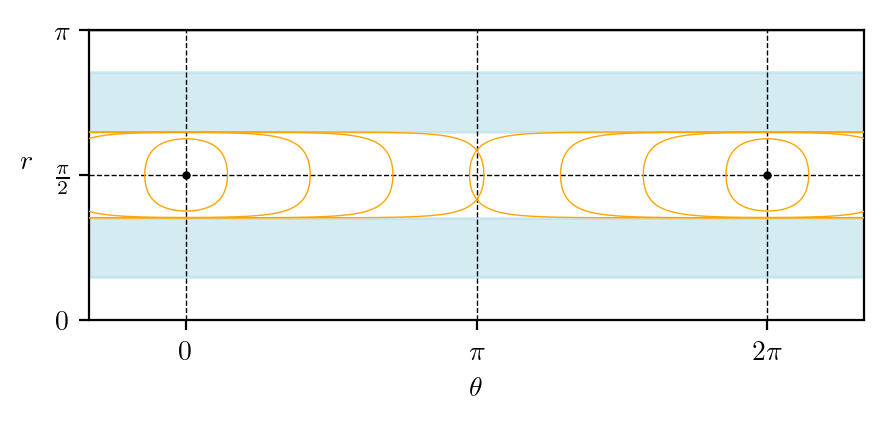

In [14]:
fig2d_wavefront.savefig('lindblad_d_gt_0_pi_2_2D_wavefront.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_wavefront

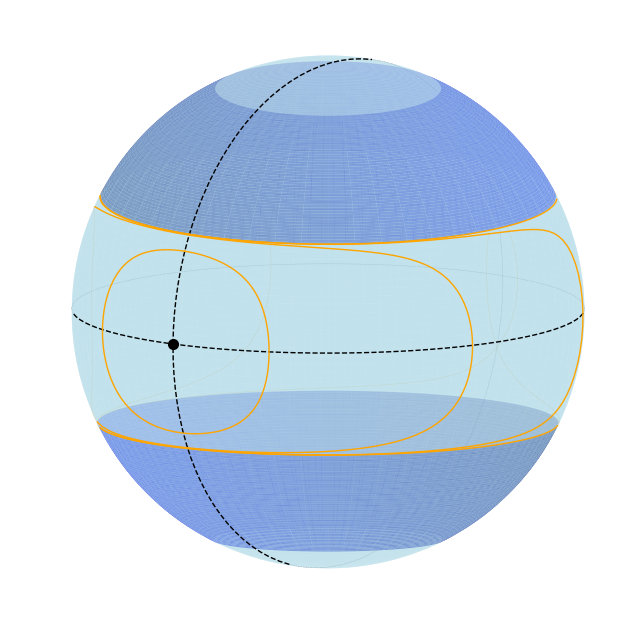

In [15]:
figs3d_wavefront[0].savefig('lindblad_d_gt_0_pi_2_3D_wavefront.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_wavefront[0]

In [16]:
if False:
    # cut locus
    # steps: 1. find a self intersection of a wavefront. 2. compute the cut locus
    tf = 7.2
    wl = wavefront.get_from_label__(tf, 'left')['locus']
    wr = wavefront.get_from_label__(tf, 'right')['locus']
    curve = np.concatenate((wr.states, wl.states))
    αs    = np.concatenate((wr.alphas, wl.alphas))
    intersections = wavefront.get_data_from_self_intersections(tf, curve, αs, modulo=2.0*np.pi)
    print(intersections[0])
    print(intersections[1])

    intersection = intersections[1]
    t  = intersection[0]
    α1 = intersection[1]
    α2 = intersection[2]
    q  = intersection[3]
    intersection = (t, α2, α1, q)

(7.2, -0.00021940518348644375, 3.141811833146961, array([1.30547593, 3.14149121]))
(7.2, 0.00021914999679793252, 3.1413740021867174, array([1.83498152, 3.14139072]))


In [17]:
# test for initial alpha = 0
α0 = 0.0
tf = 7.0
qf = prob.geodesic(tf, α0)[-1]
print(np.abs(qf[1]-np.pi))

def fun(t, α):
    return (prob.geodesic(t, 0)[-1] % (2.0*np.pi)) - (prob.geodesic(t, α)[-1] % (2.0*np.pi))

t_guess = 7.0
α_guess = np.pi
y_guess = np.array([t_guess, α_guess])
sol = nt.nle.solve(lambda y: fun(y[0], y[1]), y_guess)

intersection_equator = (sol.x[0], np.pi, 0.0, prob.geodesic(sol.x[0], 0)[-1])

0.01109748509008579

     Calls  |f(x)|                 |x|
 
         1  2.219497018017158e-02  7.672653022331282e+00
         2  1.477136189139749e-09  7.695298979463588e+00
         3  1.818103177642396e-12  7.695298980971181e+00

 Results of the nle solver method:

 xsol    =  [7.02481473 3.14159265]
 f(xsol) =  [-1.81810123e-12  2.66453526e-15]
 nfev    =  3
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



In [18]:
# find the initial angle such that q(t, α0) = (r_barrier - gap, pi)
gap = 1e-2
r_barrier = rm2
θ0 = 0.0
def fun(t, α):
    return prob.geodesic(t, α)[-1] - np.array([r_barrier - gap, θ0+np.pi])

t_guess = 9.0
α_guess = 0.0004
y_guess = np.array([t_guess, α_guess])
sol = nt.nle.solve(lambda y: fun(y[0], y[1]), y_guess)

α0_cut = -sol.x[1]
αf_cut = -α0_cut

print('α0_cut = ', α0_cut)
print('αf_cut = ', αf_cut)


     Calls  |f(x)|                 |x|
 
         1  1.898757280599786e-02  9.000000008888890e+00
         2  4.919749103381910e-04  8.825959002476218e+00
         3  2.049739718364249e-04  8.866225235369061e+00
         4  2.268591152983187e-05  8.855125657330888e+00
         5  8.616828460568135e-07  8.856142279505425e+00
         6  7.422537325577058e-09  8.856104205705961e+00
         7  1.540886229746003e-11  8.856103876815675e+00
         8  5.370542509574172e-14  8.856103877486822e+00

 Results of the nle solver method:

 xsol    =  [8.85610387e+00 3.79215552e-04]
 f(xsol) =  [5.32907052e-14 6.66133815e-15]
 nfev    =  8
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

α0_cut =  -0.0003792155523989185
αf_cut =  0.0003792155523989185


In [19]:
splitting = geometry2d.splitting.Splitting(prob)
opt = nt.path.Options(MaxStepSizeHomPar=0.05, Display='off')
cut = splitting.compute(intersection_equator, [α0_cut, αf_cut], label='meridian', options=opt, reset=False)
t_cut = splitting.splitting_time(cut)
def t_end(α, t):
    α = α % (2.0*np.pi)
    a = min(α0_cut % (2.0*np.pi), αf_cut % (2.0*np.pi))
    b = max(α0_cut % (2.0*np.pi), αf_cut % (2.0*np.pi))
    if α <= a or α >= b:
        return t_cut(α)
    elif np.pi-a <= α and α <= 3*np.pi-b:
        return t_cut(α)
    else:
        return t
# check if r from cut locus is contained in the weak domain: [np.pi/2.0 + rm1, np.pi/2.0 + rp1]
r = cut.states[:, 0]
print('r = ', r)
print('rmin = ', np.min(r))
print('rmax = ', np.max(r))
print('rp2 = ', rp2)
print('rm2 = ', rm2)
np.all(rp2 <= r) and np.all(r <= rm2)

r =  [1.1171487  1.11739049 1.12016802 1.12586681 1.1360401  1.15311392
 1.18140048 1.20589812 1.24158952 1.27608595 1.31498021 1.36509534
 1.4146462  1.46178387 1.51061885 1.56125941 1.61582962 1.66496944
 1.70688884 1.744924   1.78040172 1.81514055 1.85026943 1.88268271
 1.91051333 1.93452661 1.95523521 1.9730738  1.98825089 2.00090053
 2.01112698 2.01906784 2.02444396]
rmin =  1.117148696005943
rmax =  2.024443957597863
rp2 =  1.1071487177940904
rm2 =  2.0344439357957027


True

In [20]:
# plot geodesics and cut locus
LW_CUT = 1.8
LW_GEO = 0.8

# plot cut locus
fig2d_synthesis = splitting.plot(['meridian'], linewidth=LW_CUT, view=PLANE, color=color_cut_locus, 
                                 figsize=(5,5))
fig2d_synthesis = update_2d_plot(fig2d_synthesis)
fig2d_synthesis = geometry2d.utils.plot_2d_domain(fig2d_synthesis, rp1, rp2, color_strong_domain_2d)
fig2d_synthesis = geometry2d.utils.plot_2d_domain(fig2d_synthesis, rm1, rm2, color_strong_domain_2d)

cameras = [{'azimuth': 140, 'elevation': -10}, {'azimuth': 40, 'elevation': -10}]
figs3d_synthesis = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d_synthesis = splitting.plot(['meridian'], linewidth=LW_CUT, view=SPHERE, color=color_cut_locus, 
                                     azimuth=azimuth, elevation=elevation, figsize=(3,3))
    fig3d_synthesis = geometry2d.utils.plot_3d_domain(fig3d_synthesis, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d_synthesis = geometry2d.utils.plot_3d_domain(fig3d_synthesis, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d_synthesis.append(fig3d_synthesis)
        
# add geodesics to t_end(α, tf)
tf = 3*np.pi
αspan_a = np.linspace(0.0, αf_cut, 3)
αspan_b = np.logspace(np.log10(αf_cut), np.log10(np.pi/2), 9)
αspan_1 = np.concatenate((αspan_a, αspan_b))
αspan   = np.concatenate((αspan_1, np.pi-αspan_1))
αspan   = np.concatenate((αspan, 2.0*np.pi - αspan))
fig2d_synthesis = geodesic.plot(alphas=αspan, tf=lambda α: t_end(α, tf),
                                view=PLANE, color=color_hyperbolic, figure=fig2d_synthesis, force=True)

for fig3d_synthesis in figs3d_synthesis:
    fig3d_synthesis = geodesic.plot(alphas=αspan, tf=lambda α: t_end(α, tf),
                                    view=SPHERE, color=color_hyperbolic, figure=fig3d_synthesis, force=True)

<Figure size 640x480 with 0 Axes>

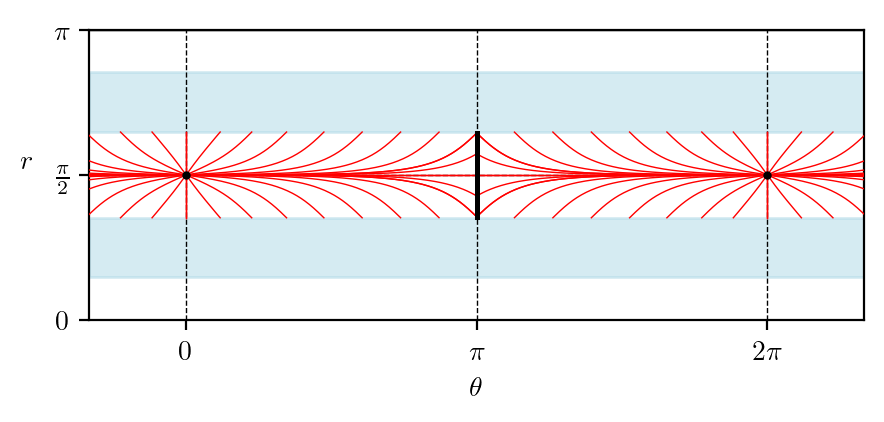

In [21]:
fig2d_synthesis.savefig('lindblad_d_gt_0_pi_2_2D_synthesis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_synthesis

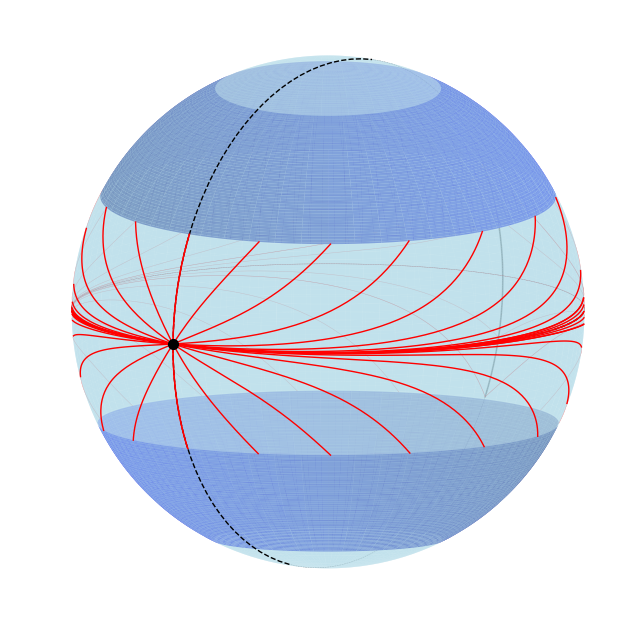

In [22]:
figs3d_synthesis[0].savefig('lindblad_d_gt_0_pi_2_3D_synthesis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_synthesis[0]

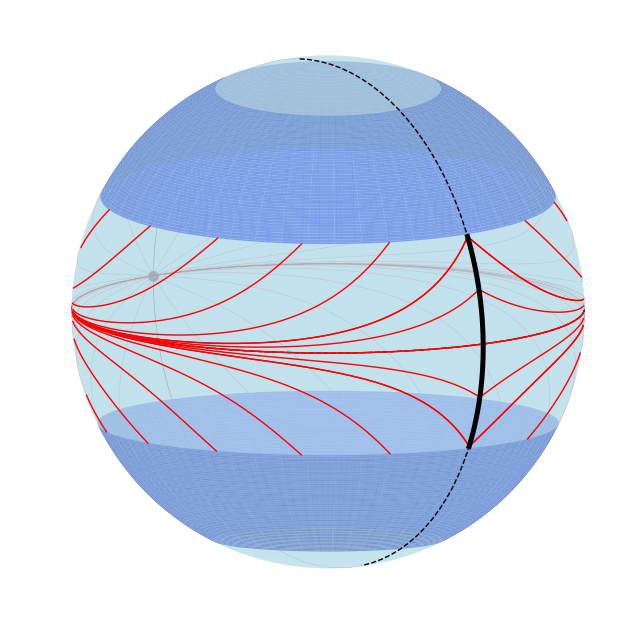

In [23]:
figs3d_synthesis[1].savefig('lindblad_d_gt_0_pi_2_3D_synthesis_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_synthesis[1]

In [25]:
# spheres
def t_cut_final(α):
    α = α % (2.0*np.pi)
    a = min(α0_cut % (2.0*np.pi), αf_cut % (2.0*np.pi))
    b = max(α0_cut % (2.0*np.pi), αf_cut % (2.0*np.pi))
    if α <= a or α >= b:
        return t_cut(α)
    elif np.pi-a <= α and α <= 3*np.pi-b:
        return t_cut(α)
    else:
        return np.inf

sphere = geometry2d.sphere.Sphere(wavefront, t_cut_final)
if True:
    for tf in tfs_wavefronts:
        print(tf)
        sphere.compute(tf, reset=False)

1.0
3.0
5.0
7.2


In [26]:
LW_SPHERE_2D = 0.8
LW_SPHERE_3D = 1.2

tfs = [1.0, 3.0, 5.0, 7.2]
cameras = [{'azimuth': 140, 'elevation': -10}, {'azimuth': 40, 'elevation': -10}]
for i in range(len(tfs)):
    tf = tfs[i]
    if i == 0:
        fig2d_sphere = sphere.plot(tf, view=PLANE, color=color_sphere, figsize=(5,5), linewidth=LW_SPHERE_2D)
        fig2d_sphere = update_2d_plot(fig2d_sphere)
        fig2d_sphere = geometry2d.utils.plot_2d_domain(fig2d_sphere, rp1, rp2, color_strong_domain_2d)
        fig2d_sphere = geometry2d.utils.plot_2d_domain(fig2d_sphere, rm1, rm2, color_strong_domain_2d)
        figs3d_sphere = []
        for camera in cameras:
            azimuth = camera['azimuth']
            elevation = camera['elevation']
            fig3d_sphere = sphere.plot(tf, view=SPHERE, color=color_sphere, linewidth=LW_SPHERE_3D, 
                                       azimuth=azimuth, elevation=elevation, figsize=(3,3))
            fig3d_sphere = geometry2d.utils.plot_3d_domain(fig3d_sphere, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
            fig3d_sphere = geometry2d.utils.plot_3d_domain(fig3d_sphere, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
            figs3d_sphere.append(fig3d_sphere)
    else:
        sphere.plot(tf, view=PLANE, color=color_sphere, figure=fig2d_sphere, linewidth=LW_SPHERE_2D)
        for fig3d_sphere in figs3d_sphere:
            sphere.plot(tf, view=SPHERE, color=color_sphere, figure=fig3d_sphere, linewidth=LW_SPHERE_3D)
            
# and cut locus
fig2d_sphere = splitting.plot(['meridian'], linewidth=LW_CUT, view=PLANE, color=color_cut_locus, figure=fig2d_sphere)
for fig3d_sphere in figs3d_sphere:
    fig3d_sphere = splitting.plot(['meridian'], linewidth=LW_CUT, view=SPHERE, color=color_cut_locus, figure=fig3d_sphere)

<Figure size 640x480 with 0 Axes>

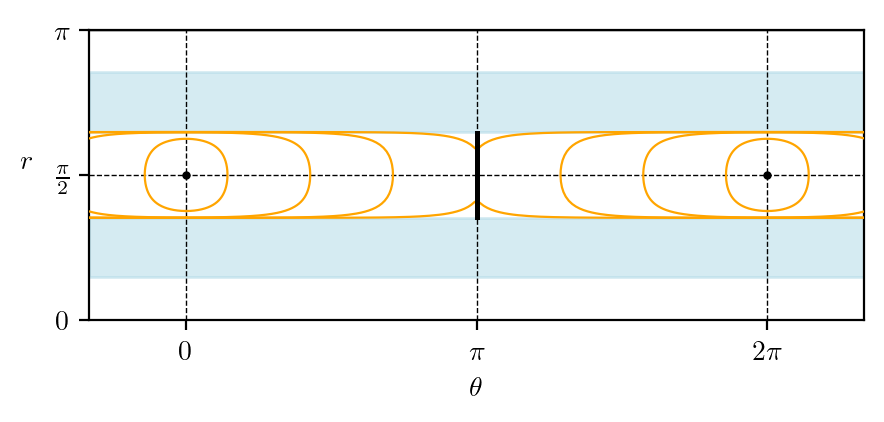

In [27]:
fig2d_sphere.savefig('lindblad_d_gt_0_pi_2_2D_sphere.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_sphere

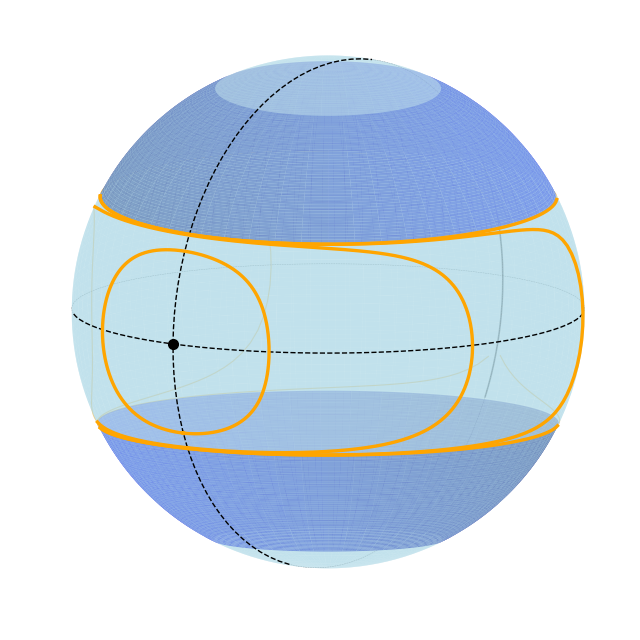

In [28]:
figs3d_sphere[0].savefig('lindblad_d_gt_0_pi_2_3D_sphere.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_sphere[0]

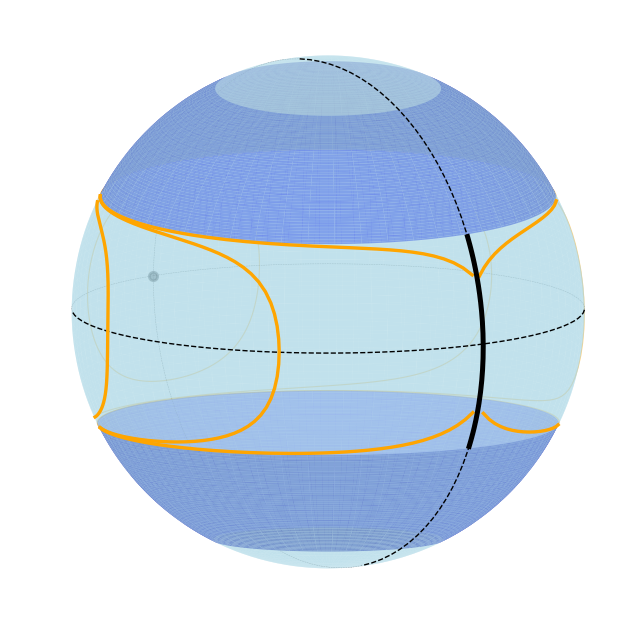

In [29]:
figs3d_sphere[1].savefig('lindblad_d_gt_0_pi_2_3D_sphere_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_sphere[1]

# Example 2

In [115]:
#
d = 1.25
r0 = np.pi/2.0 + 2.0*np.pi/8.0

# Strong domain
rp1, rp2, rm1, rm2 = get_strong_domain(d)

#
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 160, 'elevation': -10}]
fig2d, figs3d, prob = make_plots(r0, d, cameras=cameras)

# add Elliptic geodesics
αspan_elliptic = α_elliptique_span(r0, d, N=20)
geodesic = geometry2d.geodesic.Geodesic(prob)
fig3d_with_elliptic = geodesic.plot(alphas=αspan_elliptic, tf=np.pi, \
    view=geometry2d.plottings.Coords.SPHERE, figure=figs3d[1], color=color_elliptic)

α1 =  0.9272952180016123
α2 =  2.214297435588181


<Figure size 640x480 with 0 Axes>

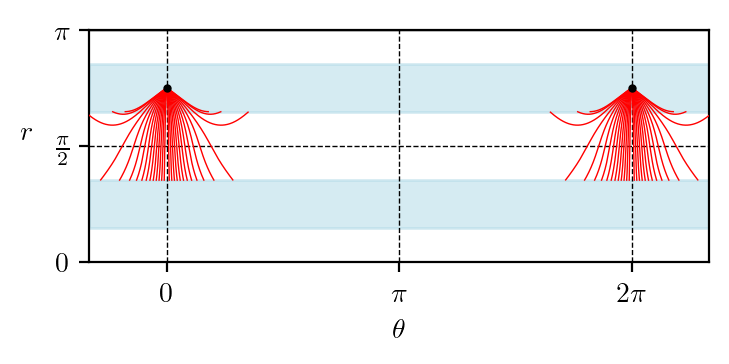

In [45]:
fig2d

In [181]:
tf = 6*np.pi
gap = 1e-2
a = 0.54835807
g = 1e-8
αspan = np.linspace(a-g, a+g, 10)
fig2d = geodesic.plot(alphas=αspan, tf=tf, view=PLANE, color=color_hyperbolic, figsize=(4,4), force=True)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1, rp2, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1, rm2, color_strong_domain_2d)

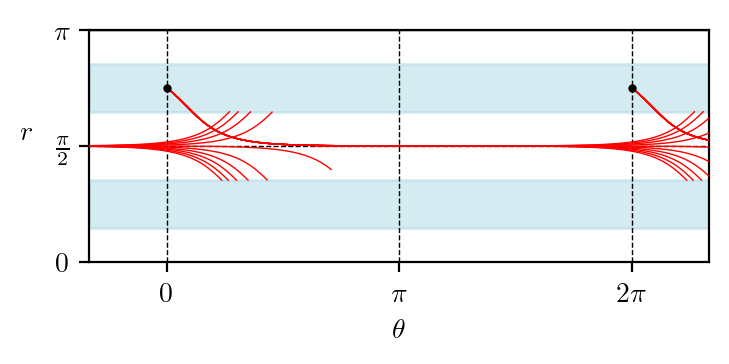

In [182]:
fig2d

In [262]:
α1 = 0.54835807
α2 = np.pi-α1

tf = 4*np.pi
NN = 8
LL = 6

αspan_a1 = -np.logspace(-LL, -1, NN) + α1
αspan_a2 =  np.logspace(-LL, -1, NN) + α1
αspan_a  = np.concatenate((αspan_a1, αspan_a2))

αspan_b1 = -np.logspace(-LL, -1, NN) + α2
αspan_b2 =  np.logspace(-LL, -1, NN) + α2
αspan_b  = np.concatenate((αspan_b1, αspan_b2))

e = 10e-1
αspan_c  = np.linspace(α1+1e-1, α2-1e-1, NN)
αspan_d1 = np.linspace(α2+1e-1, α2+e, NN//2)
αspan_d2 = np.linspace(α2+e, 2*np.pi+α1-e, NN//2)
αspan_d3 = np.linspace(2*np.pi+α1-e, 2*np.pi+α1-1e-1, NN//2)
αspan_d  = np.concatenate((αspan_d1, αspan_d2, αspan_d3))

αspan = np.concatenate((αspan_a, αspan_b, αspan_c, αspan_d))

# on enlève les doublons
αspan = np.unique(αspan) % (2.0*np.pi)

# on enlève les géodésiques elliptiques
ae = α_elliptique_span(r0, d, N=2)
α_abnormal_1 = ae[0]
α_abnormal_2 = ae[-1]
#print(αspan)
αspan = αspan[(αspan < α_abnormal_1) | (αspan > α_abnormal_2)]
print(ae)
print(αspan)

fig2d = geodesic.plot(alphas=αspan, tf=tf, view=PLANE, color=color_hyperbolic, figsize=(4,4), force=True)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1, rp2, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1, rm2, color_strong_domain_2d)

cameras = [{'azimuth': 140, 'elevation': -10}, {'azimuth': 40, 'elevation': -10}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, color=color_hyperbolic,
                                    azimuth=azimuth, elevation=elevation, figsize=(3,3), force=True)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

α1 =  0.9272952180016123
α2 =  2.214297435588181
[0.92729522 2.21429744]
[0.44835807 0.52905109 0.54463048 0.54763838 0.54821912 0.54833124
 0.54835289 0.54835707 0.54835907 0.54836325 0.5483849  0.54849702
 0.54907776 0.55208566 0.56766505 0.64835807 0.91191186 2.2296808
 2.49323458 2.57392761 2.58950699 2.5925149  2.59309563 2.59320776
 2.5932294  2.59323358 2.59323558 2.59323976 2.59326141 2.59337353
 2.59395427 2.59696218 2.61254156 2.69323458 2.99323458 3.29323458
 3.59323458 4.33933751 5.08544045 5.83154338 6.13154338 0.14835807
 0.44835807]


<Figure size 640x480 with 0 Axes>

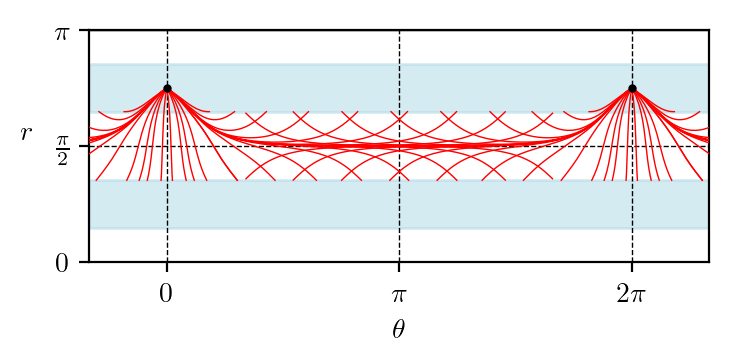

In [263]:
fig2d.savefig('lindblad_d_gt_0_pi_4_2D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d

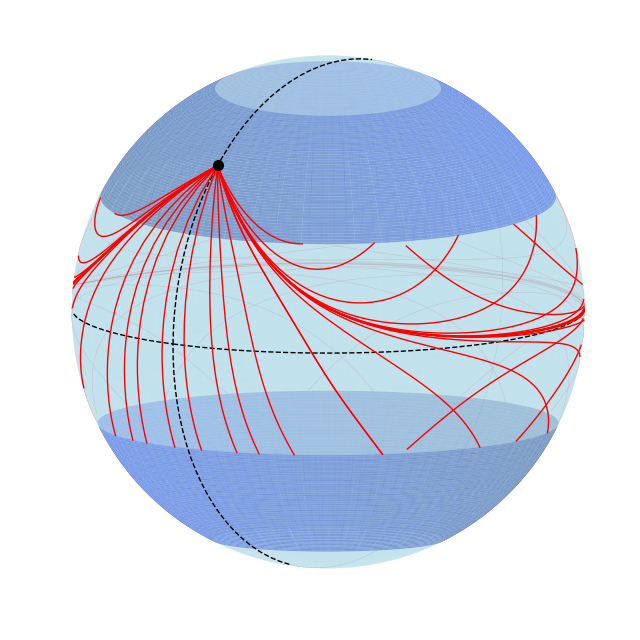

In [264]:
figs3d[0].savefig('lindblad_d_gt_0_pi_4_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

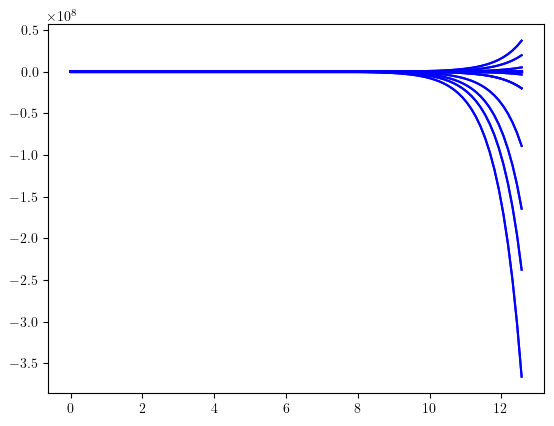

In [265]:
for α0 in αspan:
    t0 = prob.initial_time
    q0 = prob.initial_point
    p0 = prob.covector(q0, α0)
    tspan = list(np.linspace(t0, tf, 100))
    q, p = prob.extremal(t0, q0, p0, tspan)
    pr = [p[i][0] for i in range(len(p))]
    plt.plot(tspan, pr, color='blue')

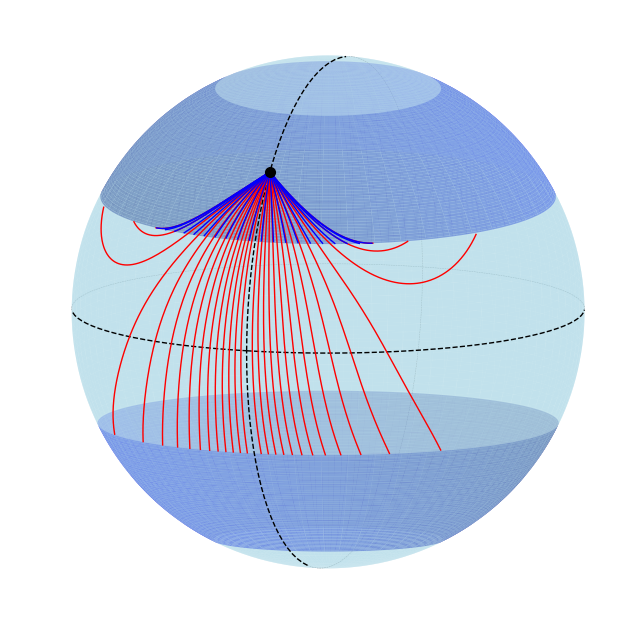

In [266]:
fig3d_with_elliptic

# Example 3

In [290]:
d = 1.25
r0 = np.pi/2.0 + 3.0*np.pi/8.0
fig2d, figs3d, prob = make_plots(r0, d)
geodesic = geometry2d.geodesic.Geodesic(prob)

<Figure size 640x480 with 0 Axes>

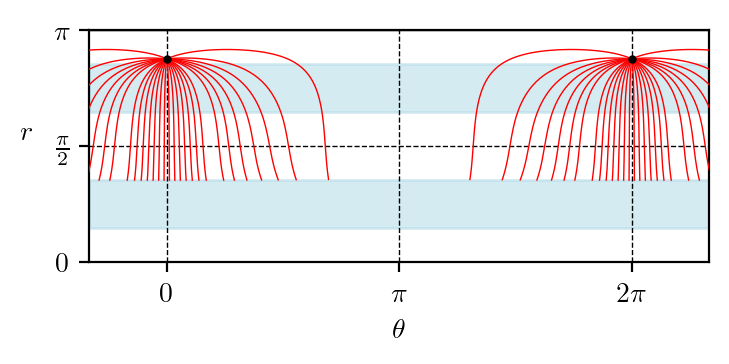

In [283]:
fig2d

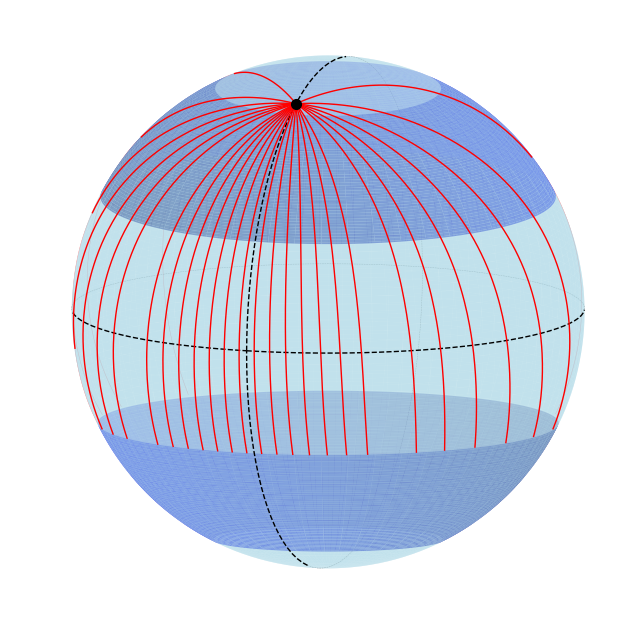

In [284]:
figs3d[0].savefig('lindblad_d_gt_0_5pi_8_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

In [307]:
α1 = np.pi/2

tf = 1*np.pi
NN = 10
LL = 2

αspan_a1 = -np.logspace(-LL, 0, NN) + α1
αspan_a2 =  np.logspace(-LL, 0, NN) + α1
αspan_a  = np.concatenate((αspan_a1, αspan_a2))
αspan_b = α_hyperbolique_span(r0, d, N=31)
αspan = np.concatenate((αspan_a, αspan_b))

# on enlève les doublons
αspan = np.unique(αspan) #% (2.0*np.pi)

fig2d = geodesic.plot(alphas=αspan, tf=tf, view=PLANE, color=color_hyperbolic, figsize=(4,4), force=True)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1, rp2, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1, rm2, color_strong_domain_2d)

cameras = [{'azimuth': 140, 'elevation': -10}, {'azimuth': 40, 'elevation': -10}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, color=color_hyperbolic,
                                    azimuth=azimuth, elevation=elevation, figsize=(3,3), force=True)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

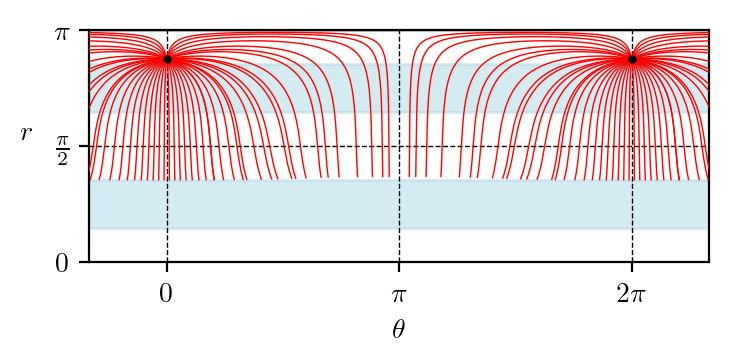

In [309]:
fig2d.savefig('lindblad_d_gt_0_5pi_8_2D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d

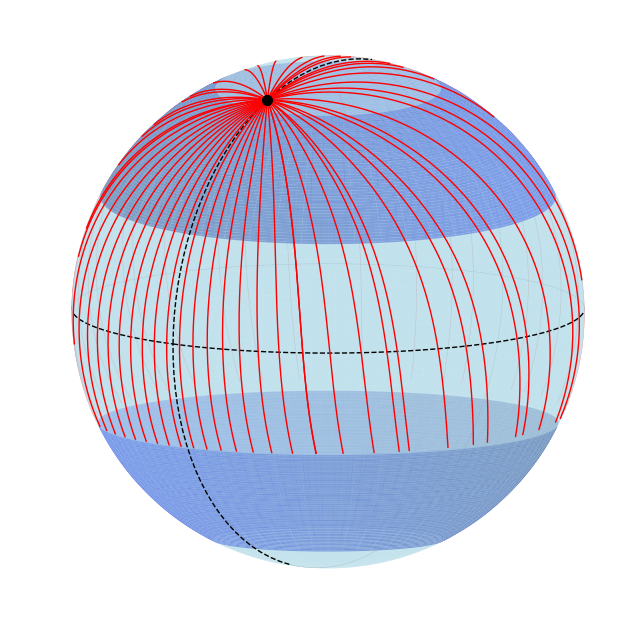

In [310]:
figs3d[0].savefig('lindblad_d_gt_0_5pi_8_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

# Example 4

In [311]:
d = -1.25
r0 = np.pi/2.0
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 20, 'elevation': -25}]
fig2d, figs3d, prob = make_plots(r0, d, cameras=cameras)
geodesic = geometry2d.geodesic.Geodesic(prob)

<Figure size 640x480 with 0 Axes>

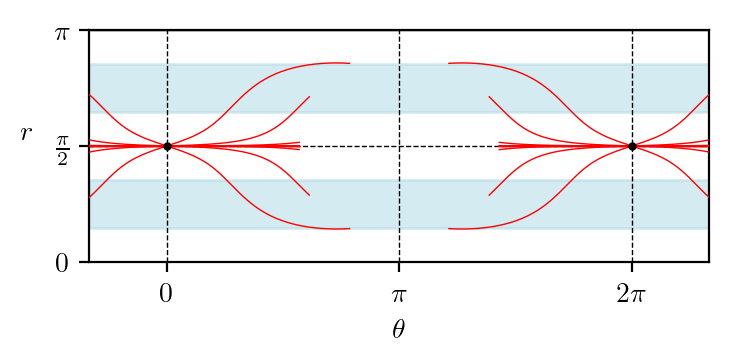

In [271]:
fig2d

In [346]:
α1 = 0
α2 = np.pi/2

NN = 10
LL = 4

αspan_a1 = -np.logspace(-LL, -1, NN) + α1
αspan_a2 =  np.logspace(-LL, -1, NN) + α1
αspan_a  = np.concatenate((αspan_a1, αspan_a2))

LL = 2

αspan_b1 = -np.logspace(-LL, -1, NN) + α2
αspan_b2 =  np.logspace(-LL, -1, NN) + α2
αspan_b  = np.concatenate((αspan_b1, αspan_b2))

αspan_c = np.linspace(0, 2*np.pi, 41)
αspan = np.concatenate((αspan_a, αspan_a+np.pi, αspan_b, αspan_b+np.pi, αspan_c))

def tf_fun(α):
    e = 3e-1
    if np.abs(α) < e or np.abs(α-np.pi) < e:
        return 5*np.pi
    else:
        return 1*np.pi

# on enlève les doublons
αspan = np.unique(αspan) #% (2.0*np.pi)

# on enlève les alphas tels que cos(alpha) < 0
αspan = αspan[np.cos(αspan) >= 0]

fig2d = geodesic.plot(alphas=αspan, tf=tf_fun, view=PLANE, color=color_hyperbolic, figsize=(4,4), force=True)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1, rp2, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1, rm2, color_strong_domain_2d)

cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 20, 'elevation': -25}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf_fun, view=SPHERE, color=color_hyperbolic,
                                    azimuth=azimuth, elevation=elevation, figsize=(3,3), force=True)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1, rp2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1, rm2, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

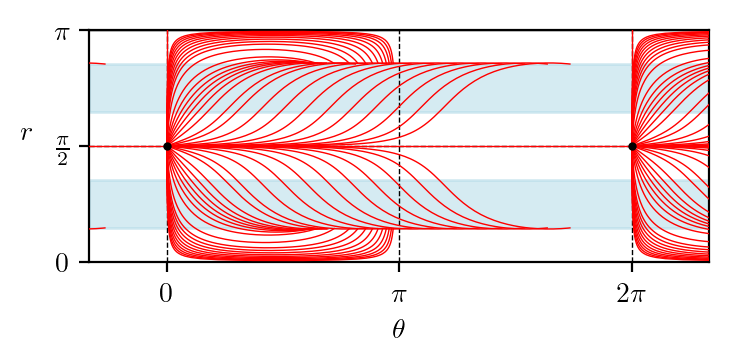

In [347]:
fig2d.savefig('lindblad_d_lt_0_pi_2_2D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d

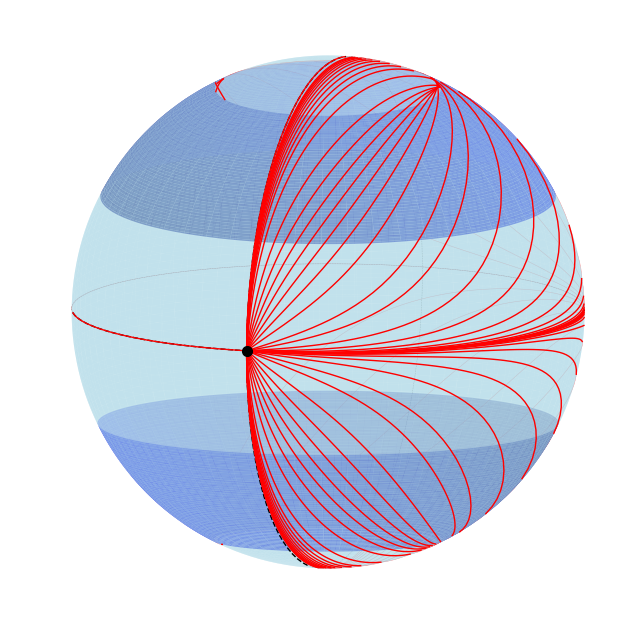

In [348]:
figs3d[0].savefig('lindblad_d_lt_0_pi_2_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

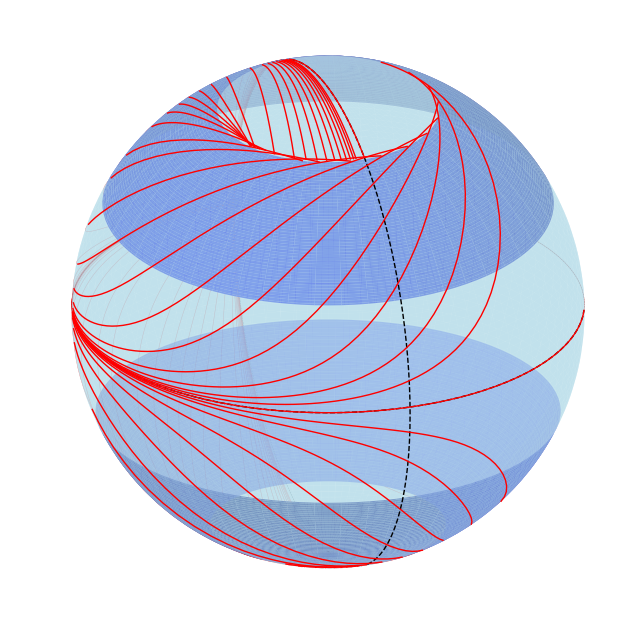

In [349]:
figs3d[1].savefig('lindblad_d_lt_0_pi_2_3D_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[1]

# Example 5

In [274]:
d = -1.25
r0 = np.pi/2.0 + 2.0*np.pi/8.0
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 160, 'elevation': -40}]
fig2d, figs3d, prob = make_plots(r0, d, cameras=cameras)

<Figure size 640x480 with 0 Axes>

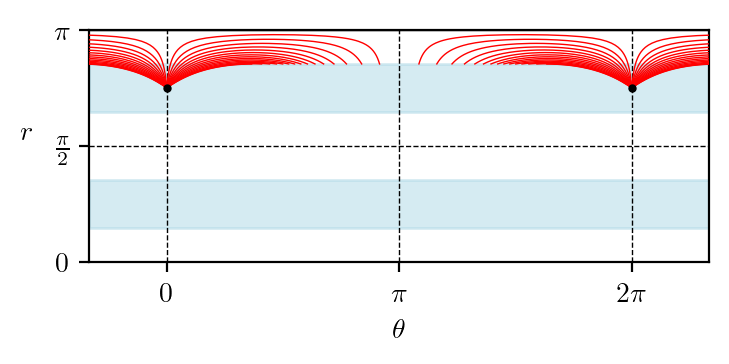

In [275]:
fig2d

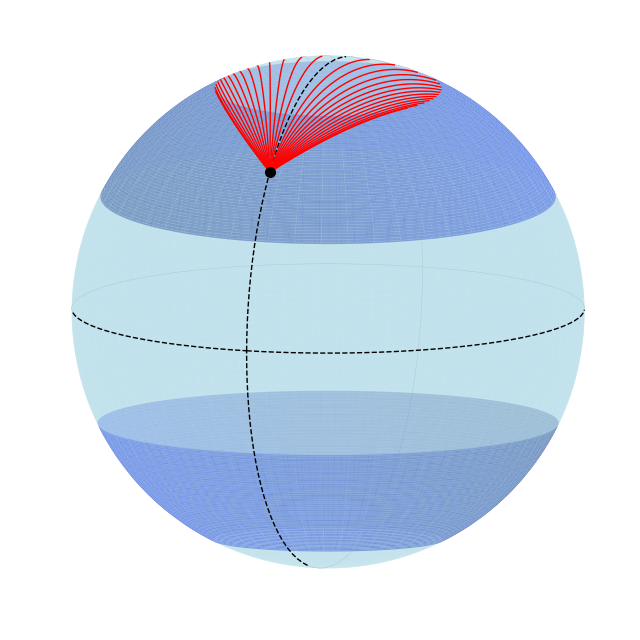

In [276]:
figs3d[0].savefig('lindblad_d_lt_0_pi_4_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

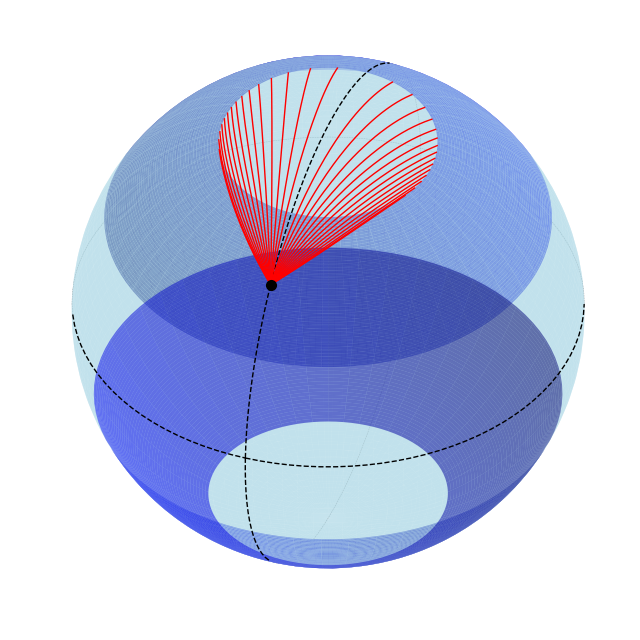

In [277]:
figs3d[1].savefig('lindblad_d_lt_0_pi_4_3D_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[1]

# Example 6

In [278]:
d = -1.25
r0 = np.pi/2.0 + 3.0*np.pi/8.0
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 160, 'elevation': -40}]
fig2d, figs3d, prob = make_plots(r0, d, cameras=cameras)

<Figure size 640x480 with 0 Axes>

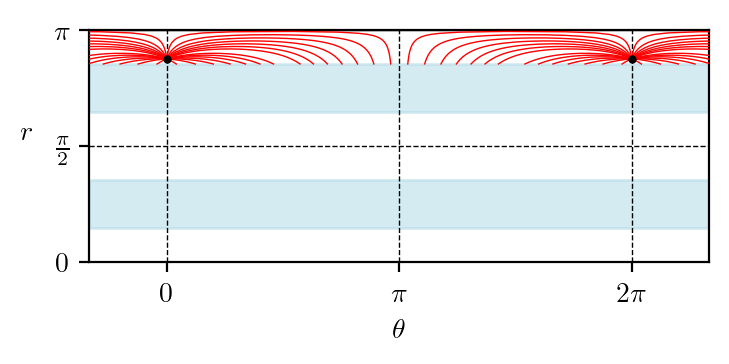

In [279]:
fig2d

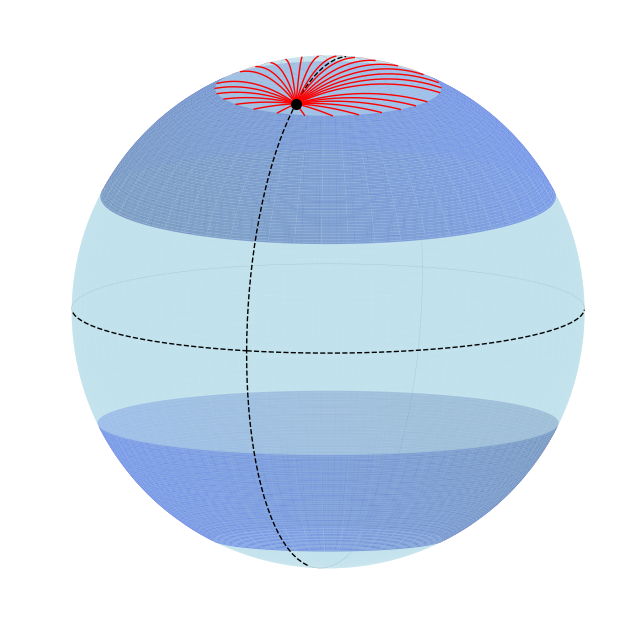

In [280]:
figs3d[0].savefig('lindblad_d_lt_0_5pi_8_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

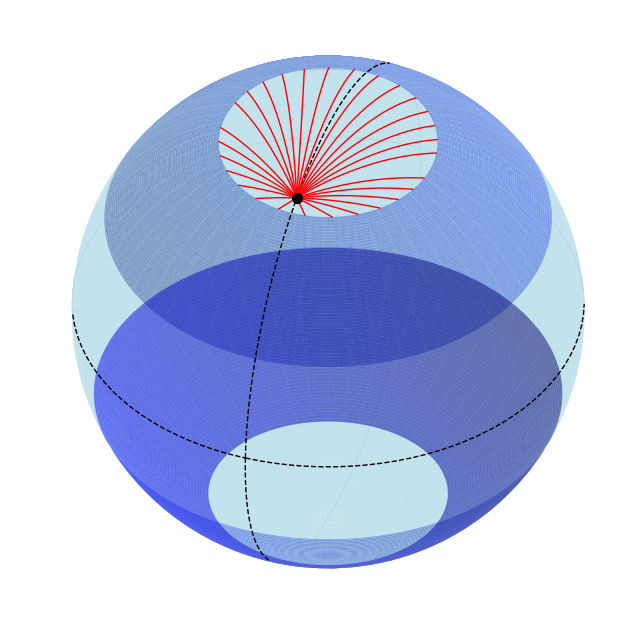

In [281]:
figs3d[1].savefig('lindblad_d_lt_0_5pi_8_3D_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[1]